<h1 align="center" style="color: orange">Transformer Architecture</h1>

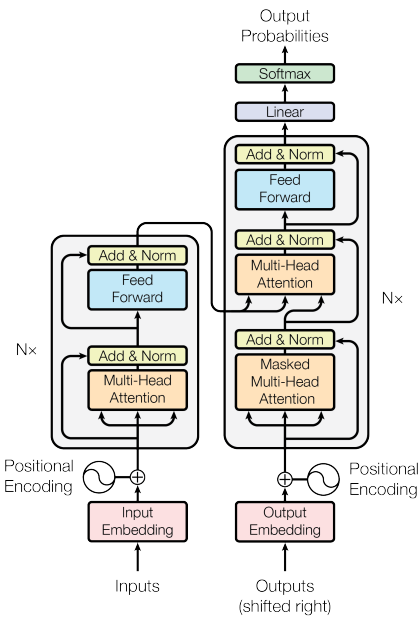
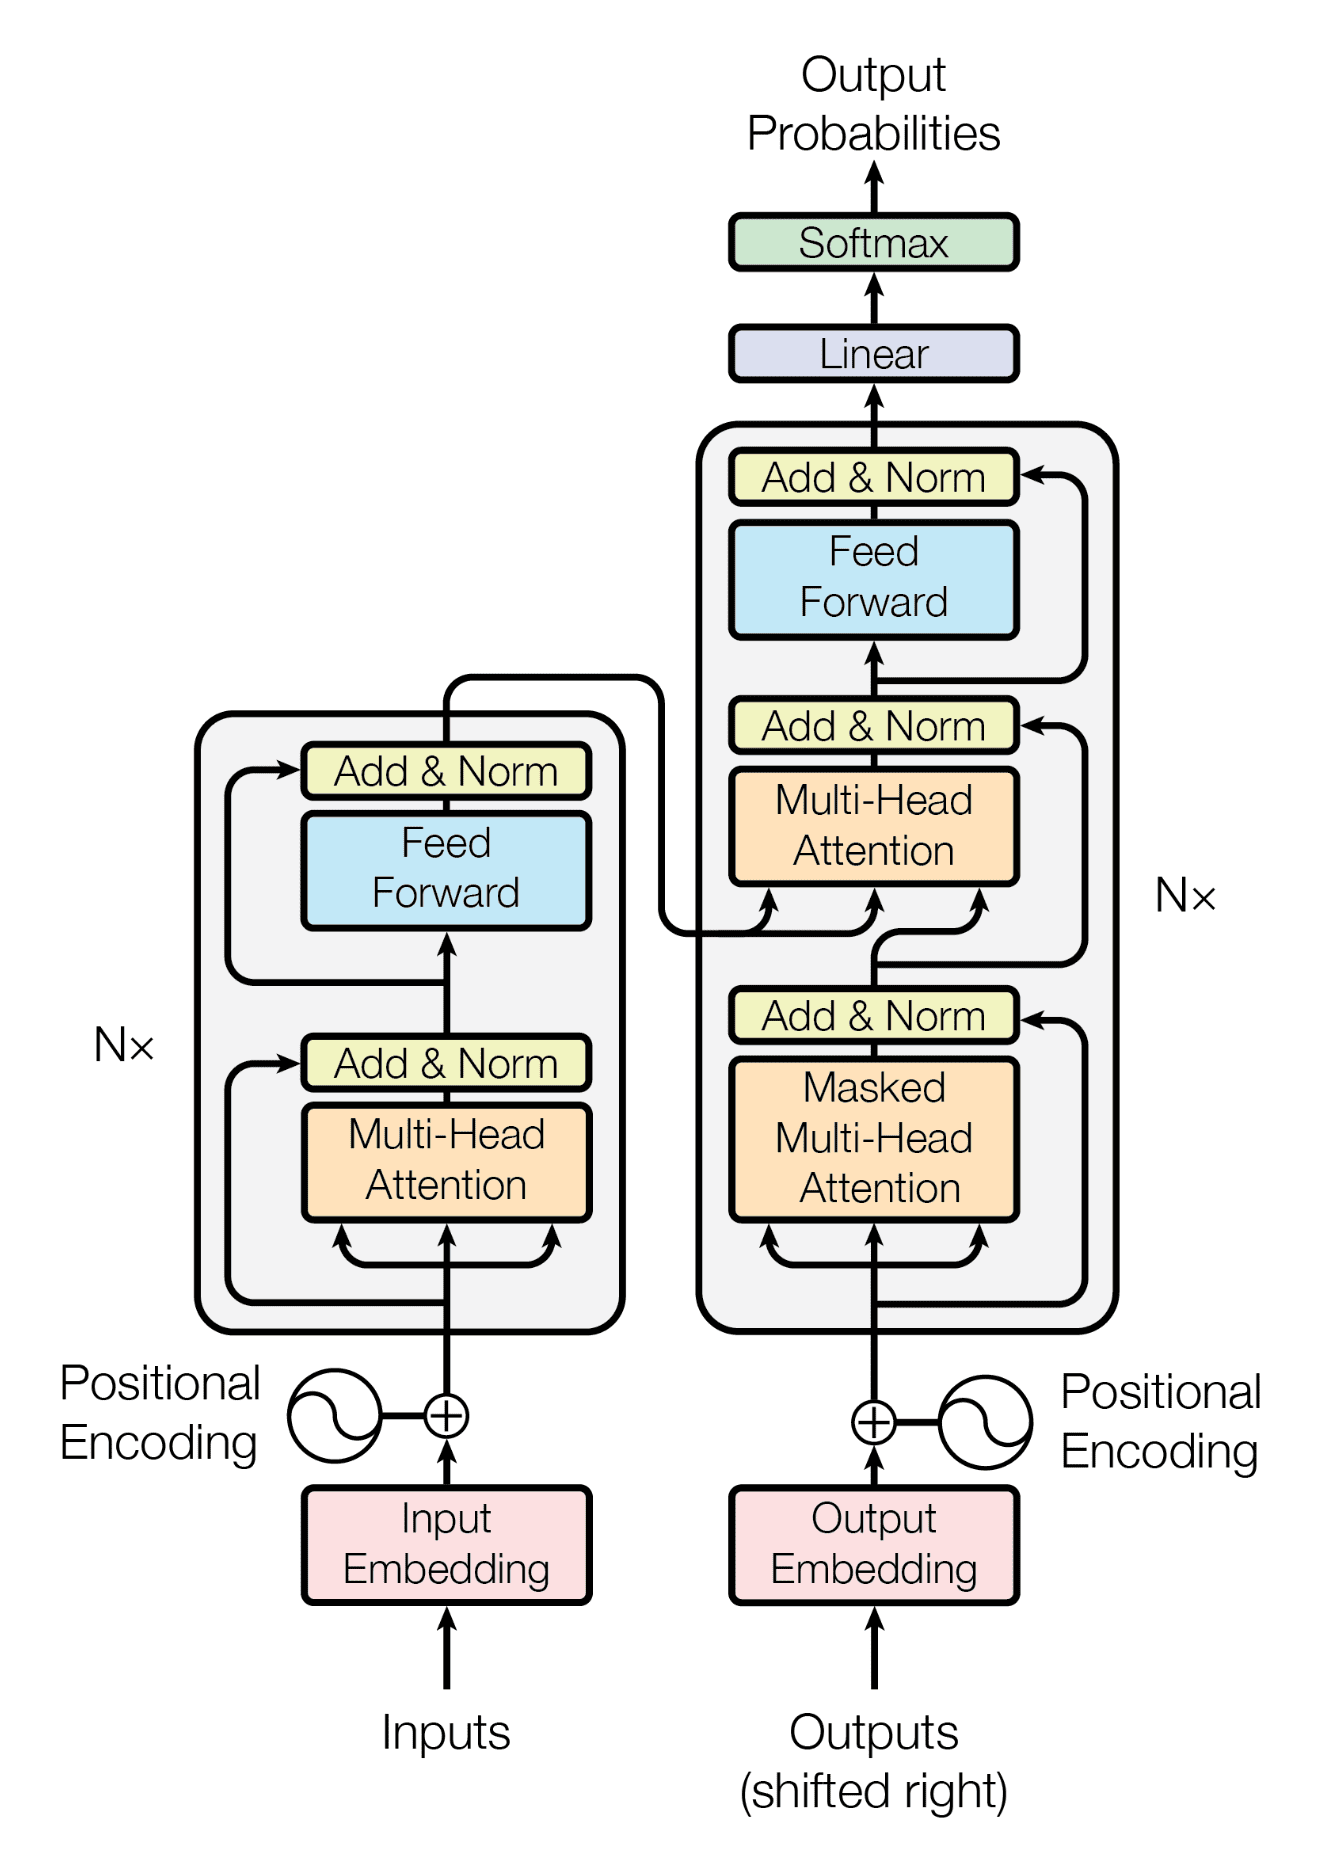

<h1 align="center" style="color: orange">Importing Libraries</h1>

In [3]:
import torch
import torch.nn as nn
import math

<h1 align="center" style="color: orange">Step 1: Input Embeddings</h1>

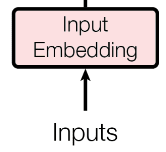

In [5]:
class InputEmbeddings(nn.Module):
    
    def __init__(self, d_model: int, vocab_size: int) -> None:
        super().__init__()
        self.d_model = d_model # dimension of embedding vectors
        self.vocab_size = vocab_size # how many words in the dictionary
        self.embedding = nn.Embedding(vocab_size, d_model)
        
    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)

<h1 align="center" style="color: orange">Step 2: Positional Encoding</h1>

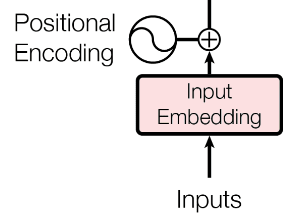

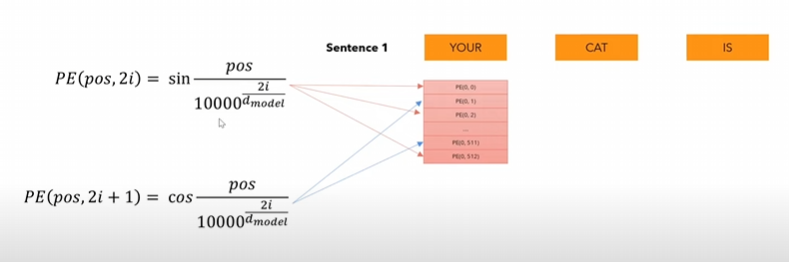

In [6]:
class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)
        
        #create matrix of shape (seq_len, d_model)
        pe = torch.zeros(seq_len, d_model)
        
        #create a vector of shape (seq_len, 1)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model).float() * (-math.log(10000.0) / d_model))
        #apply sin to even positions
        pe[:,0::2] = torch.sin(position * div_term)
        #apply consin to odd positions
        pe[:,1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0) # (1, seq_len, d_model)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + (self.pe[:,:x.shape[1], :]).requires_grad(False)
        return self.dropout(x)

<h1 align="center" style="color: orange">Step 3: Encoder</h1>

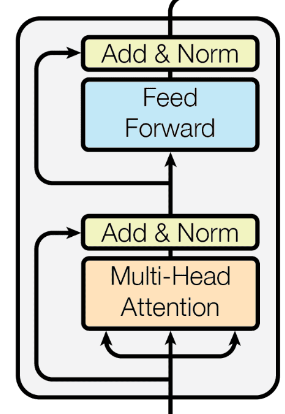

<h1 align="center" style="color: orange">Step 3.1: Add and Norm Layer</h1>

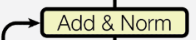
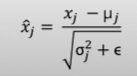

In [7]:
class LayerNormalisation(nn.Module):
    
    def __init__(self, eps: float = 10**-6) -> None:
        super().__init__()
        self.eps = eps # epsilon is added for numerical stability
        
        self.alpha = nn.Parameter(torch.ones(1)) # multiplied
        self.bias = nn.Parameter(torch.zeros(1)) # additive
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim = -1, keepdim=True)
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

<h1 align="center" style="color: orange">Step 3.2: Feed Forward Layer</h1>

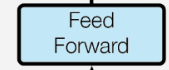
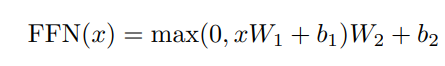

In [8]:
class FeedForwardBlock(nn.Module):
    
    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff) # w1 and b1 (bias is there by default)
        self.linear_2 = nn.Linear(d_ff, d_model) # w2 and b2
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, d_ff) --> (batch, seq_len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

<h1 align="center" style="color: orange">Step 3.3: Multihead Attention block</h1>

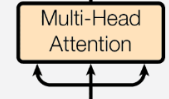
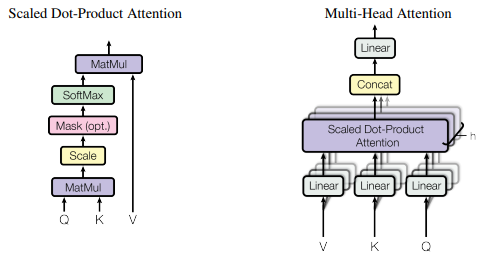

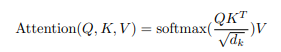
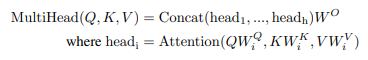

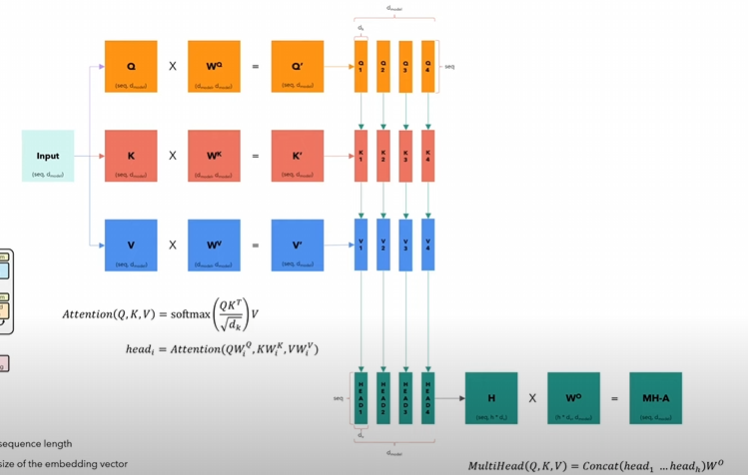

In [9]:
class MultiHeadAttentionBlock(nn.Module):

    def __init__(self,d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.h = h
        assert d_model % h == 0, "d_model is divisible by h"

        self.d_k = d_model // h

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)

        self.w_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
    
    @staticmethod
    def attention(query, key, value, mask, dropout):
        d_k = query.shape[-1]
        
        # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            attention_scores.masked_fill_(mask==0, -1e9)
        attention_scores = attention_scores.softmax(dim = -1) # (batch, h, seq_len, seq_len)
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(k) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(v) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        
        # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) --> (batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)
        
        x, self.attention_scores = self.attention(query, key, value, mask, self.dropout)
        
        # (batch, h, seq_len, d_k) --> (batch, seq_len, h, seq_len) --> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)
        
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        return self.w_o(x)

<h1 align="center" style="color: orange">Step 3.4: Making residual connections</h1>

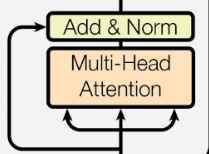

In [10]:
class ResidualConnection(nn.Module):
    
    def __init__(self, dropout: float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalisation()
    
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

<h1 align="center" style="color: orange">Step 3.5: Completing the encoder</h1>

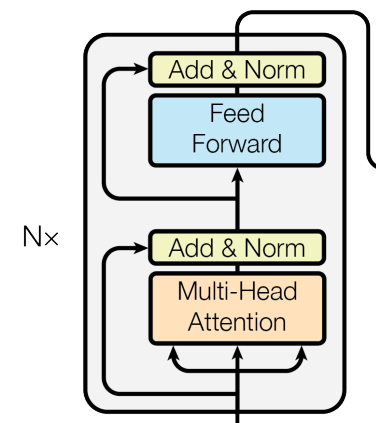

In [11]:
class EncoderBlock(nn.Module):
    
    def __init__(self, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection for _ in range(2)])
    
    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

In [12]:
class Encoder(nn.Module):
    
    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalisation()
    
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

<h1 align="center" style="color: orange">Step 4: Making the Decoder</h1>

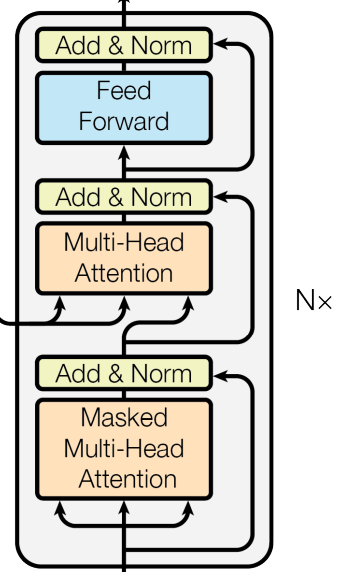

In [13]:
class DecoderBlock(nn.Module):
    
    def __init__(self, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)])
    
    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.self_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

In [14]:
class Decoder(nn.Module):
    
    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init()
        self.layers = layers
        self.norm = LayerNormalisation()
    
    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

<h1 align="center" style="color: orange">Step 5: Projection Layer</h1>

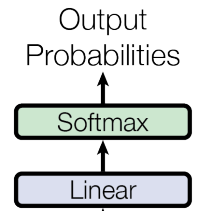

In [15]:
class ProjectionLayer(nn.Module):
    
    def __init__(self, d_model: int, vocab_size: int) -> None:
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)
    
    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, vocab_size)
        return torch.log_softmax(self.proj(x), dim=-1)

<h1 align="center" style="color: orange">Step 6: Connecting Everything</h1>

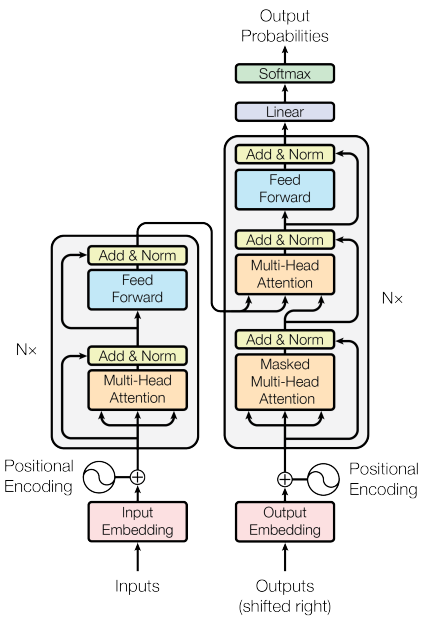

In [16]:
class Transformer(nn.Module):
    
    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer
    
    def encode(self, src, src_mask):
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)
    
    def decode(self, encoder_output, src_mask, tgt, tgt_mask):
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)
    
    def project(self, x):
        return self.projection_layer(x)

In [17]:
def TransformerModel(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int = 512, N: int = 6, h: int = 8, dropout: float = 0.1, d_ff: int = 2048) -> Transformer:
    # creating embedding layers
    src_embed = InputEmbeddings(d_model, src_vocab_size)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)
    
    # creating positional encoding layers
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)
    
    # create the encoder blocks
    encoder_blocks = []
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)
    
    # create the decoder blocks
    decoder_blocks = []
    for _ in range(N):
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)
    
    # create the encoder and the decoder
    encoder = Encoder(nn.ModuleList(encoder_blocks))
    decoder = Decoder(nn.ModuleList(decoder_blocks))
    
    # create the projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)
    
    # create the transformer
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)
    
    # initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_normal_(p)
    
    return transformer